In [23]:
import time
import subprocess
import matplotlib.pyplot as plt
import psutil
import os
import re
import threading
import csv
import signal
import numpy as np
import math
import fcntl
import select
from pathlib import Path
from dataclasses import dataclass
import resource
import cProfile
import pstats
import errno
import datetime

In [26]:
@dataclass
class Result:
    returncode: int
    stdout: str
    stderr: str
    duration: float
    rusage: resource.struct_rusage

class ResourcePopen(subprocess.Popen):
    def _try_wait(self, wait_flags):
        try:
            (pid, sts, res) = os.wait4(self.pid, wait_flags)
        except OSError as e:
            if e.errno != errno.ECHILD:
                raise
            pid = self.pid
            sts = 0
        else:
            self.rusage = res
        return (pid, sts)

def resource_call(*popenargs, timeout=None, **kwargs) -> Result:
    with ResourcePopen(*popenargs, stdout=subprocess.PIPE, stderr=subprocess.PIPE, **kwargs) as p:
        start = datetime.datetime.now()
        try:
            stdout, stderr = p.communicate(timeout=timeout)
        except:
            p.kill()
            stdout, stderr = p.communicate()
            raise
        stop = datetime.datetime.now()
        return Result(p.returncode, stdout.decode(), stderr.decode(), (stop - start).total_seconds(), p.rusage)

In [14]:
models = ["DT_generator","IDT_generator","subroutine_generator"]

In [ ]:
directory = './grammars'
files = os.listdir(directory)
print(files)

In [15]:
## compile the programs
for model in models:
    subprocess.run(["clang++", "-O3", "-std=c++20", "-o", model, model+".cpp"])

In [16]:
depth = [1,2,4,8,16,32,64,128,256,512,1024,2048]

In [ ]:
result = {}
timeout = 5  # Timeout for each test in seconds

def set_non_blocking(fd):
    """Set the file descriptor to non-blocking mode."""
    flags = fcntl.fcntl(fd, fcntl.F_GETFL)
    fcntl.fcntl(fd, fcntl.F_SETFL, flags | os.O_NONBLOCK)

def estimate_energy(cpu_utilization, duration):
    return cpu_utilization * duration

for i in range(len(models)):
    program_name = models[i]
    result[program_name] = {}
    for j in range(len(files)):
        file_name = files[j]
        result[program_name][file_name] = {}
        for k in range(len(depth)):
            depth_value = depth[k]
            current_file_name = f"{program_name}_{depth_value}_{file_name}.fth"
            
            pre_compile = subprocess.run(
                ["./"+program_name, "-p", f"./grammars/{file_name}", "-d", str(depth_value), "-o", current_file_name,"--endless"],
                check=True
            )
            instruction_latency = []
            cpu_usage_start = psutil.cpu_percent(interval=None)
            
            process = ResourcePopen(
                ["gforth-fast", current_file_name, "-e", "bye"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                text=True
            )

            set_non_blocking(process.stdout.fileno())
            set_non_blocking(process.stderr.fileno())

            start_time = time.time()
            total_bytes = 0
            
            try:
                while time.time() - start_time < timeout:
                    ready, _, _ = select.select([process.stdout, process.stderr], [], [], 1)
                    for stream in ready:
                        before_read = time.time()
                        line = stream.readline()
                        if line:
                            total_bytes += len(line.encode('utf-8'))
                            after_read = time.time()  # Record time after reading output
                            latency = after_read - before_read
                            instruction_latency.append(latency)

            except Exception as e:
                print(f"Error occurs: {e}")
            finally:
                process.kill()
                process.wait()
            
            average_latency = np.mean(instruction_latency) if instruction_latency else 0
            print(f"Average Instruction Latency: {average_latency:.6f} seconds")

            cpu_usage_end = psutil.cpu_percent(interval=None)
            cpu_utilization = (cpu_usage_end - cpu_usage_start) / 100
            duration = time.time() - start_time
            energy_consumed = estimate_energy(cpu_utilization, duration)
            print(f"Energy Consumed: {energy_consumed:.6f} Joules")

            print(f"Total Bytes: {total_bytes}")
            output_speed = total_bytes / timeout
            rusage= process.rusage
            
            result[program_name][file_name][depth_value] = {
                'output_speed': output_speed,
                'average_latency': average_latency,
                'energy_consumed': energy_consumed,
                'cpu_time': rusage.ru_utime + rusage.ru_stime,
                'memory': rusage.ru_maxrss,
                'page_faults': rusage.ru_minflt + rusage.ru_majflt,
                'io_input': rusage.ru_inblock,
                'io_output': rusage.ru_oublock,
                'context_switches': rusage.ru_nvcsw + rusage.ru_nivcsw
            }

            print(f"{program_name} {file_name} {depth_value} {output_speed:.2f} Bytes/s")

print(result)


In [ ]:
with open('results.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Program', 'File', 'Depth', 'Average Throughput Rate (MB/s)', 'Average Instruction Latency (s)', 'Energy Consumed (Joules)', 'CPU Time (s)', 'Max RSS (kB)', 'Page Faults', 'I/O Input', 'I/O Output', 'Context Switches'])
    
    for program_name, files_dict in result.items():
        for file_name, depths_dict in files_dict.items():
            for depth_value, data in depths_dict.items():
                if isinstance(data, dict):
                     writer.writerow([
                        program_name,
                        file_name,
                        depth_value,
                        data['output_speed'] / 1024 / 1024,
                        data.get('average_latency', 'N/A'),
                        data.get('energy_consumed', 'N/A'),
                        data['cpu_time'],
                        data['memory'],
                        data['page_faults'],
                        data['io_input'],
                        data['io_output'],
                        data['context_switches']
                        ])
                else:
                    print(f"Error: Expected dictionary for {program_name}, {file_name}, {depth_value}, but got {type(data)}")

print("Results have been written to results.csv")

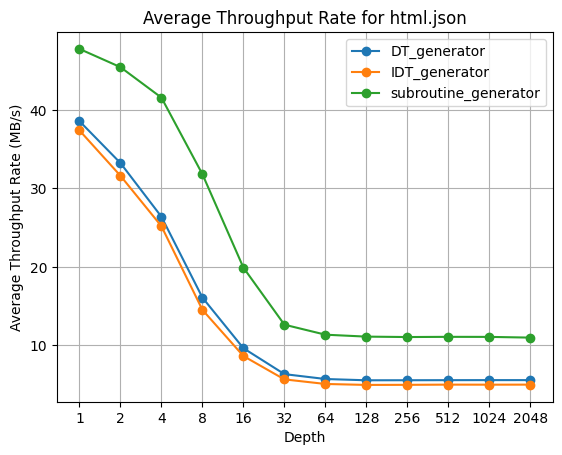

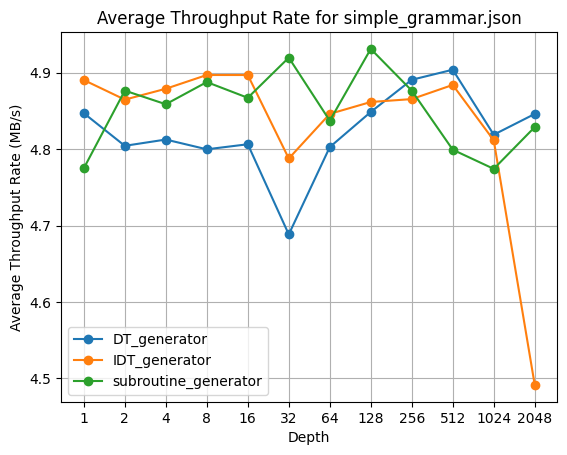

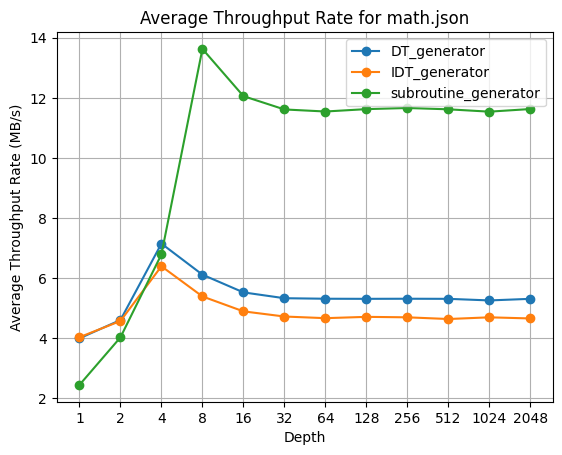

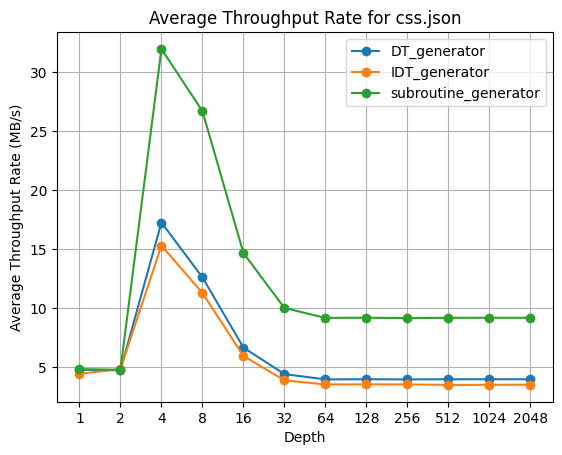

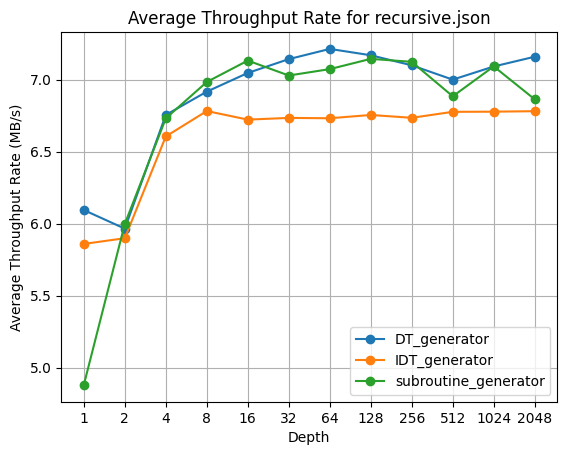

In [35]:
csv_filename = 'results.csv'

results = {}

with open(csv_filename, mode='r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        program_name = row['Program']
        file_name = row['File']
        dp = int(row['Depth'])
        avg_throughput_rate = float(row['Average Throughput Rate (MB/s)'])

        if program_name not in results:
            results[program_name] = {}
        if file_name not in results[program_name]:
            results[program_name][file_name] = {}

        if dp not in results[program_name][file_name]:
            results[program_name][file_name][dp] = []
        
        results[program_name][file_name][dp].append(avg_throughput_rate)

for file_name in {file_name for program_data in results.values() for file_name in program_data.keys()}:
    plt.figure()
    for program_name in results.keys():
        if file_name in results[program_name]:
            depths = sorted(results[program_name][file_name].keys())
            rates = [results[program_name][file_name][d] for d in depths]
            plt.plot([math.log(x,2) for x in depths], rates, marker='o', label=program_name)
    
    plt.xlabel('Depth')
    plt.ylabel('Average Throughput Rate (MB/s)')
    plt.title(f'Average Throughput Rate for {file_name}')
    plt.legend()
    plt.grid(True)

    plt.xticks([math.log(x,2) for x in depths], [str(d) for d in depths])

    plt.savefig(f"{file_name}_throughput.png")
    plt.show()

In [34]:

import glob

current_directory = os.getcwd()
files = glob.glob(os.path.join(current_directory, '*.fth'))

for file in files:
    try:
        os.remove(file)
        print(f'Deleted: {file}')
    except Exception as e:
        print(f'Error deleting {file}: {e}')


Deleted: /Users/apple/gForthVM/subroutine_generator_8_html.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_1024_math.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_2_math.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_1_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_1_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_16_simple_grammar.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_128_css.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_2048_recursive.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_128_math.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_128_math.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_8_html.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_8_simple_grammar.json.fth
Deleted: /Users/apple/gForthVM/DT_generator_128_simple_grammar.json.fth
Deleted: /Users/apple/gForthVM/subroutine_generator_1024_math.json.fth
Deleted: /Users/apple/gForthVM/IDT_generator_2_math.json.ft